<a href="https://colab.research.google.com/github/shh2003/Machine-Learning/blob/main/week04/Mhealth_LSTM%2BCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D
from tensorflow.keras.layers import concatenate
from keras.utils import to_categorical


In [2]:
from google.colab import drive
import pandas as pd
import glob
import re

# Google Drive 마운트
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# MHEALTHDATASET 폴더 경로
data_path = "/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET"

# 모든 .log 파일 경로 가져오기
log_files = glob.glob(data_path + "/mHealth_subject*.log")

print("파일 목록:")
for f in log_files:
    print(f)


파일 목록:
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject3.log
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject4.log
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject10.log
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject2.log
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject1.log
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject8.log
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject7.log
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject6.log
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject5.log
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject9.log


In [4]:
# 각 파일을 데이터프레임으로 읽어 리스트에 저장합니다.
all_data_frames = []
for file_path in log_files:
    # 파일을 데이터프레임으로 읽어옵니다. (탭으로 구분, 헤더 없음)
    df = pd.read_csv(file_path, sep='\t', header=None)

    # 파일 경로에서 subject 번호를 추출합니다.

    match = re.search(r'subject(\d+)', file_path)
    if match:
        subject_id = int(match.group(1))
        # 'subject' 열을 추가합니다.
        df['subject'] = subject_id
        all_data_frames.append(df)

# 모든 데이터프레임을 하나로 통합합니다.

combined_df = pd.concat(all_data_frames, ignore_index=True)



combined_df.head()



,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,subject
0,-9.4674,0.13721,1.0545,0.23862,-0.033490,-0.18848,-9.8425,0.90183,0.55659,-0.83490,...,2.0431,1.3105,-0.75490,-0.22998,0.78233,-1.605100,1.0685,-3.65290,0,3
1,-9.5991,0.15481,1.1824,0.22606,-0.079540,-0.36263,-9.7832,0.89263,0.55659,-0.83490,...,1.8242,1.4245,-0.75490,-0.22998,0.78233,-2.101500,5.2904,0.62709,0,3
2,-9.8612,0.13317,1.0646,0.20513,-0.096285,-0.24823,-9.8010,1.09080,0.57885,-0.84615,...,2.4401,1.0074,-0.75490,-0.22998,0.78233,0.565620,2.7021,-1.45980,0,3
3,-9.6398,0.17406,1.2367,0.18420,-0.062794,-0.25027,-9.6730,1.01380,0.57885,-0.84615,...,1.9019,1.1888,-0.75490,-0.22998,0.78233,0.244770,6.5233,-0.78236,0,3
4,-10.0360,0.26062,1.2761,0.12559,-0.025118,-0.20668,-9.9102,1.05450,0.57885,-0.84615,...,2.0140,1.4028,-0.75294,-0.22998,0.76293,0.034368,3.4368,-1.11670,0,3


In [5]:
# MHEALTH 데이터셋의 컬럼명을 순서대로 리스트로 정의합니다.

column_names = [
    'acc_ch_x', 'acc_ch_y', 'acc_ch_z', # Chest Accelerometer
    'ecg_1', 'ecg_2',                  # Electrocardiogram (이 부분이 추가되었습니다)
    'acc_la_x', 'acc_la_y', 'acc_la_z', # Left-Ankle Accelerometer
    'gyr_la_x', 'gyr_la_y', 'gyr_la_z', # Left-Ankle Gyroscope
    'mag_la_x', 'mag_la_y', 'mag_la_z', # Left-Ankle Magnetometer
    'acc_rw_x', 'acc_rw_y', 'acc_rw_z', # Right-Wrist Accelerometer
    'gyr_rw_x', 'gyr_rw_y', 'gyr_rw_z', # Right-Wrist Gyroscope
    'mag_rw_x', 'mag_rw_y', 'mag_rw_z', # Right-Wrist Magnetometer
    'activity',
    'subject'
]

combined_df.columns = column_names
# 결과 확인

print("\n## 📊 데이터프레임 미리보기")
combined_df


## 📊 데이터프레임 미리보기


,acc_ch_x,acc_ch_y,acc_ch_z,ecg_1,ecg_2,acc_la_x,acc_la_y,acc_la_z,gyr_la_x,gyr_la_y,...,acc_rw_y,acc_rw_z,gyr_rw_x,gyr_rw_y,gyr_rw_z,mag_rw_x,mag_rw_y,mag_rw_z,activity,subject
0,-9.4674,0.13721,1.054500,0.23862,-0.033490,-0.18848,-9.8425,0.90183,0.556590,-0.83490,...,2.0431,1.3105,-0.75490,-0.22998,0.78233,-1.605100,1.0685,-3.65290,0,3
1,-9.5991,0.15481,1.182400,0.22606,-0.079540,-0.36263,-9.7832,0.89263,0.556590,-0.83490,...,1.8242,1.4245,-0.75490,-0.22998,0.78233,-2.101500,5.2904,0.62709,0,3
2,-9.8612,0.13317,1.064600,0.20513,-0.096285,-0.24823,-9.8010,1.09080,0.578850,-0.84615,...,2.4401,1.0074,-0.75490,-0.22998,0.78233,0.565620,2.7021,-1.45980,0,3
3,-9.6398,0.17406,1.236700,0.18420,-0.062794,-0.25027,-9.6730,1.01380,0.578850,-0.84615,...,1.9019,1.1888,-0.75490,-0.22998,0.78233,0.244770,6.5233,-0.78236,0,3
4,-10.0360,0.26062,1.276100,0.12559,-0.025118,-0.20668,-9.9102,1.05450,0.578850,-0.84615,...,2.0140,1.4028,-0.75294,-0.22998,0.76293,0.034368,3.4368,-1.11670,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215740,-12.2440,-2.97060,-0.035772,0.81214,1.096800,0.57061,-2.5602,0.41936,-0.055659,0.64165,...,-16.9660,2.3704,0.10980,-0.99384,0.19181,-6.128700,15.4950,18.85600,0,9
1215741,-10.9220,-3.41900,-0.339280,1.46940,1.285200,5.26840,-4.9331,9.66020,-0.055659,0.64165,...,-13.3900,2.9972,0.10980,-0.99384,0.19181,-10.242000,17.1390,33.92000,0,9
1215742,-9.4842,-3.06430,-1.033700,0.23862,0.891680,0.53805,-5.9706,2.93600,-0.055659,0.64165,...,-11.3790,3.1498,0.10980,-0.99384,0.19181,-12.944000,16.1700,43.26200,0,9
1215743,-8.7889,-2.47570,-0.612290,-0.20513,0.460490,1.56950,-7.9809,-2.05000,-0.085343,0.43715,...,-10.0000,3.0000,0.11961,-0.97331,0.15302,-14.524000,1.8494,43.37300,0,9


In [6]:
combined_df.columns

Index(['acc_ch_x', 'acc_ch_y', 'acc_ch_z', 'ecg_1', 'ecg_2', 'acc_la_x',
       'acc_la_y', 'acc_la_z', 'gyr_la_x', 'gyr_la_y', 'gyr_la_z', 'mag_la_x',
       'mag_la_y', 'mag_la_z', 'acc_rw_x', 'acc_rw_y', 'acc_rw_z', 'gyr_rw_x',
       'gyr_rw_y', 'gyr_rw_z', 'mag_rw_x', 'mag_rw_y', 'mag_rw_z', 'activity',
       'subject'],
      dtype='object')

In [7]:
combined_df.isnull().sum()

,0
acc_ch_x,0
acc_ch_y,0
acc_ch_z,0
ecg_1,0
ecg_2,0
acc_la_x,0
acc_la_y,0
acc_la_z,0
gyr_la_x,0
gyr_la_y,0


In [8]:
combined_df['subject'].value_counts()

,count
subject,
1,161280
9,135168
2,130561
8,129024
3,122112
5,119808
4,116736
7,104448
10,98304


In [9]:
print("## 'activity' 컬럼의 값 분포")
print(combined_df['activity'].value_counts())

## 'activity' 컬럼의 값 분포
activity
0     872550
1      30720
2      30720
3      30720
4      30720
9      30720
5      30720
11     30720
10     30720
7      29441
8      29337
6      28315
12     10342
Name: count, dtype: int64


In [10]:
combined_df.shape

(1215745, 25)

In [11]:
X = combined_df.drop(['subject', 'activity'], axis=1)
y = combined_df['activity']

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# 1. LabelEncoder 객체를 생성합니다.
encoder = LabelEncoder()

# 2. fit_transform()을 사용하여 'y' 데이터를 라벨 인코딩합니다.
#    .values.reshape(-1, 1) 부분이 필요 없어 코드가 더 간단해집니다.
y_encoded = encoder.fit_transform(y)

In [14]:
print(f"특징 데이터 형태: {X_scaled.shape}")
print(f"레이블 데이터 형태: {y_encoded.shape}")

특징 데이터 형태: (1215745, 23)
레이블 데이터 형태: (1215745,)


In [15]:
window_size = 128
step = 64


window_size = 128
step = 64
X_windows, y_windows = [], []

# 윈도우 생성 루프
for i in range(0, len(X_scaled) - window_size, step):
    # 특징 데이터 윈도우 추출
    window = X_scaled[i : i + window_size]

    # 레이블 데이터 윈도우 추출
    label_vector = y_encoded[i : i + window_size]

    # ★★★ 이 부분이 변경되었습니다 ★★★
    # 1차원 배열(label_vector)에서 가장 빈번하게 등장하는 값을 찾습니다.
    # np.bincount가 각 숫자의 빈도를 세고, np.argmax가 가장 빈도가 높은 숫자를 반환합니다.
    most_common_label = np.argmax(np.bincount(label_vector))

    X_windows.append(window)
    y_windows.append(most_common_label)

# 리스트를 Numpy 배열로 변환
X_windows = np.array(X_windows)
y_windows = np.array(y_windows)

# 결과 확인
print("생성된 X 데이터 형태:", X_windows.shape)
print("생성된 y 데이터 형태:", y_windows.shape)

생성된 X 데이터 형태: (18995, 128, 23)
생성된 y 데이터 형태: (18995,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_windows, y_windows, test_size=0.2, random_state=42, stratify=y_windows
)


In [17]:
import tensorflow as tf

# --- 모델 파라미터 정의 (기존과 동일) ---
n_timesteps, n_features = X_train.shape[1], X_train.shape[2]
n_outputs = len(np.unique(y_train))


# --- CNN-LSTM 모델 구축 ---
# (기존 LSTM 모델 정의 부분을 이 코드로 교체합니다.)

model = Sequential([
    # 1. CNN 부분: 데이터의 지역적 패턴(특징)을 추출합니다.
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # 2. LSTM 부분: CNN이 추출한 특징들의 시간적 순서를 학습합니다.
    LSTM(units=100, return_sequences=True),
    Dropout(0.5),
    LSTM(units=100),
    Dropout(0.5),

    # 3. 분류기 부분: 최종적으로 활동을 분류합니다.
    Dense(100, activation='relu'),
    Dense(n_outputs, activation='softmax')
])

# --- 모델 컴파일 및 구조 확인 (기존과 동일) ---
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# --- 이후 모델 훈련 및 평가는 기존 코드와 동일하게 진행합니다 ---
# history = model.fit(...)
# results_summarizer(...)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 124, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 62, 100)        │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,645 (682.21 KB)

 Trainable params: 174,645 (682.21 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# --- 모델 컴파일 및 훈련 ---
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [19]:
# 모델 훈련
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.7167 - loss: 1.1941 - val_accuracy: 0.7513 - val_loss: 0.5721
Epoch 2/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7387 - loss: 0.6013 - val_accuracy: 0.7913 - val_loss: 0.4587
Epoch 3/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7841 - loss: 0.4674 - val_accuracy: 0.8355 - val_loss: 0.3626
Epoch 4/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8085 - loss: 0.3912 - val_accuracy: 0.8586 - val_loss: 0.3071
Epoch 5/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8381 - loss: 0.3443 - val_accuracy: 0.8439 - val_loss: 0.3282
Epoch 6/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8439 - loss: 0.3197 - val_accuracy: 0.8573 - val_loss: 0.3060
Epoch 7/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8305 - loss: 0.3391 - val_accuracy: 0.8405 - val_loss: 0.3492
Epoch 8/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8598 - loss: 0.3073 - val_acc

In [20]:
def plot_history(history):
    plt.figure(figsize=(10, 8))
    sns.set_theme()
    # --- 정확도 ---
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], 'r-', label='Train')
    plt.plot(history.history['val_accuracy'], 'b-', label='Val')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # --- 손실 ---
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], 'r-', label='Train')
    plt.plot(history.history['val_loss'], 'b-', label='Val')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

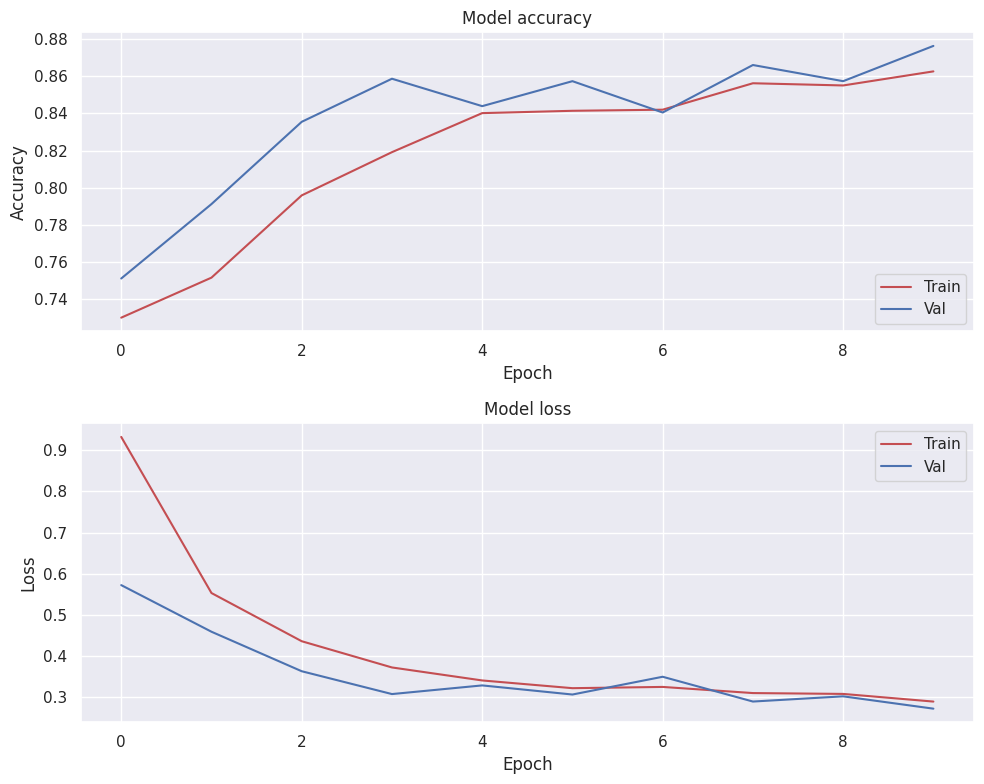

In [21]:
plot_history(history)

In [22]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
# --- 1. 모델 예측 ---
# 테스트 데이터로 모델의 예측값을 계산합니다.
y_pred_probs = model.predict(X_test)

# 예측값은 확률 형태이므로, 가장 높은 확률의 인덱스를 뽑아 1차원 배열로 만듭니다.
y_pred = np.argmax(y_pred_probs, axis=1)

# ★★★ 이 부분이 변경되었습니다 ★★★
# y_test는 이미 1차원 정수 배열이므로, 변환할 필요 없이 그대로 사용합니다.
y_true = y_test

# --- 2. 최종 결과 출력 ---
# 이제 y_true와 y_pred의 형식이 동일하므로, 아래 코드가 정상적으로 실행됩니다.
print("\n[ 분류 보고서 (Classification Report) ]")
print(classification_report(y_true, y_pred))

print("\n[ 혼동 행렬 (Confusion Matrix) ]")
print(confusion_matrix(y_true, y_pred))

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

[ 분류 보고서 (Classification Report) ]
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      2736
           1       0.61      0.99      0.75        95
           2       0.62      1.00      0.77        95
           3       0.72      1.00      0.84        95
           4       0.81      0.94      0.87        95
           5       0.69      0.96      0.80        95
           6       0.64      1.00      0.78        88
           7       0.70      0.93      0.80        91
           8       0.78      0.98      0.87        92
           9       0.73      1.00      0.84        95
          10       0.71      1.00      0.83        95
          11       0.79      0.92      0.85        95
          12       0.54      0.97      0.70        32

    accuracy                           0.88      3799
   macro avg       0.72      0.96      0.82      3799
weighted avg       0.91      0.88      0.88      3799


[

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
# --- 최종 평가 요약 함수 정의 ---
def results_summarizer(y_true, y_pred):
    """
    분류 모델의 평가 지표와 혼동 행렬을 계산하고 시각화하는 함수.

    Args:
        y_true (array): 실제 정답 레이블 (숫자 형태)
        y_pred (array): 모델의 예측 레이블 (숫자 형태)
    """
    # 1. 평가 지표 계산
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # 2. 활동 이름 맵핑 (MHEALTH 데이터셋의 13개 전체 활동)
    activity_map = {
        0: 'Null',
        1: 'Standing still',
        2: 'Sitting and relaxing',
        3: 'Lying down',
        4: 'Walking',
        5: 'Climbing stairs',
        6: 'Waist bends forward',
        7: 'Frontal elevation of arms',
        8: 'Knees bending (crouching)',
        9: 'Cycling',
        10: 'Jogging',
        11: 'Running',
        12: 'Jump front & back'
    }

    # 3. 혼동 행렬 시각화
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=activity_map.values(),
        yticklabels=activity_map.values()
    )
    plt.title('Confusion Matrix', fontsize=20)
    plt.xlabel('Predicted Activity (예측값)', fontsize=14)
    plt.ylabel('Actual Activity (실제값)', fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.show()

    # 4. 평가 점수 출력
    print("="*50)
    print("📊 최종 평가 점수")
    print("="*50)
    print(f'Accuracy Score: ' + '{:.4%}'.format(acc))
    print(f'Precision Score: ' + '{:.4%}'.format(prec))
    print(f'Recall Score: ' + '{:.4%}'.format(rec))
    print(f'F1 Score: ' + '{:.4%}'.format(f1))


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


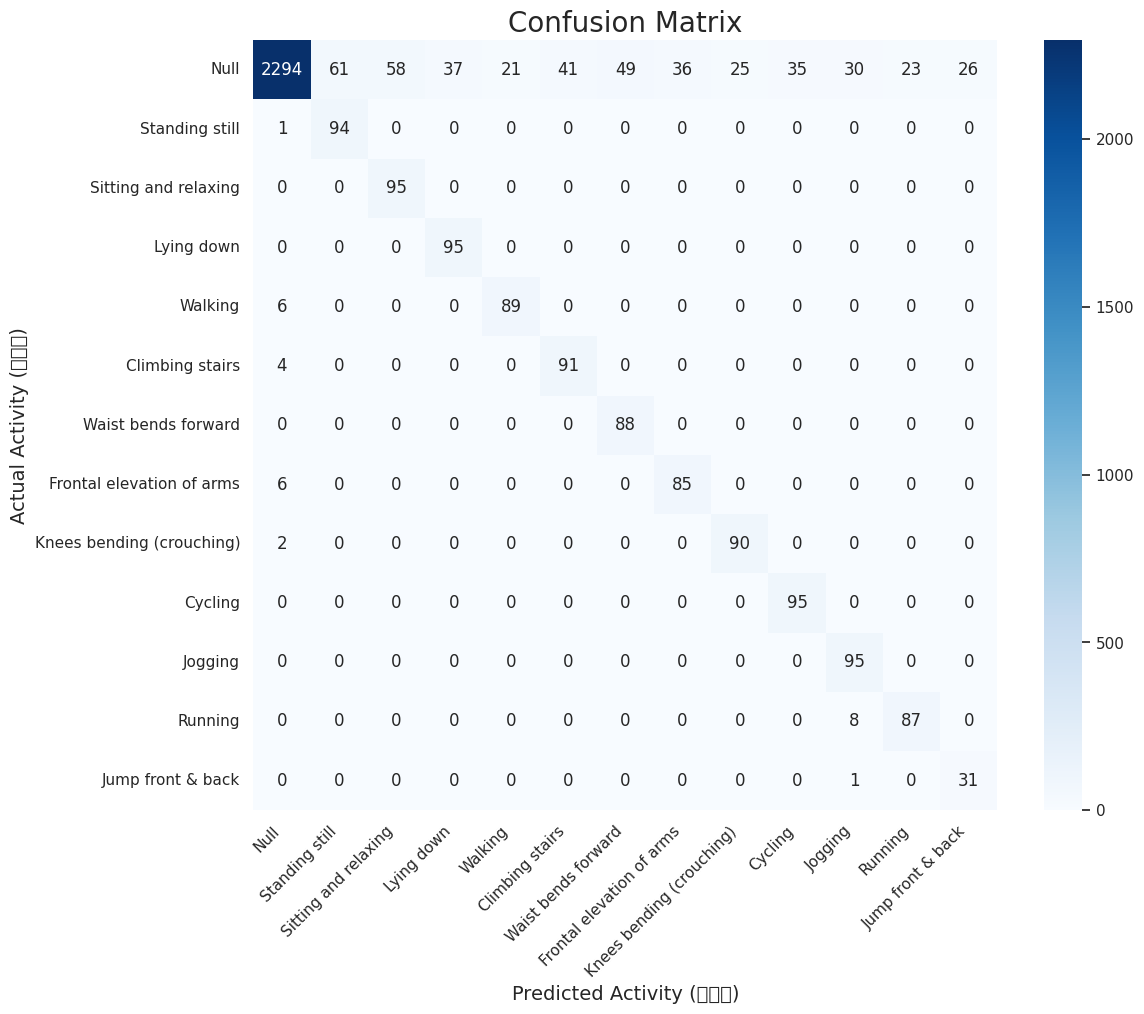

📊 최종 평가 점수
Accuracy Score: 87.6283%
Precision Score: 71.8404%
Recall Score: 96.3041%
F1 Score: 81.5931%


In [24]:
results_summarizer(y_true, y_pred)